## Problem 3: CPI and BER Data Analysis

The goal of this problem is to analyze the CPI and BER data for the last decade. The CPI (consumer price index, the price of a "market basket of consumer goods and services" - a proxy for inflation) is released monthly by the Bureau of Labor Statistics, and is given in `CPI.csv`. The file `T10YIE.csv` lists (during most of the same time period) the break-even rate (BER) , or the difference in yield between a fixed rate and inflation adjusted 10 year treasury note. This difference can be interpreted as what the market views will be the inflation rate for the next 10 years, on average.

There is more than a decade of data in `CPI.csv`. For your results to the problems below, report the mean squared prediction error for 1 month ahead forecasts starting September 2013. For example, to predict the CPI in May 2015, you can use all the data before May 2015. You should perform all of your model fitting on the months prior to September 2013, and use the remaining months for evaluation.

Additional References:

- The Consumer Price Index (CPI) is a measure of the average change over time in the prices paid by urban consumers for a market basket of consumer goods and services. To read more, visit https://www.bls.gov/cpi.
- As explained in the question above, BER is the difference in yield between a fixed rate and inflation adjusted 10 year treasury note. This difference can be interpreted as what the market views will be the inflation rate for the next 10 years, on average. To read more, visit http://www.bondeconomics.com/2014/05/primer-what-is-breakeven-inflation.html.


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.ar_model import AutoReg
from statsmodels.tsa.stattools import adfuller
import seaborn as sns

# Set the seaborn style
sns.set()

c:\Users\eddysanoli\AppData\Local\pypoetry\Cache\virtualenvs\data_analysis-ayydRhdv-py3.9\lib\site-packages\statsmodels\compat\pandas.py:65: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import Int64Index as NumericIndex


### Loading Data


CPI Columns ['date', 'CPI']

Full CPI Data Shape: (4122, 2)
Monthly CPI Data Shape: (136, 2)


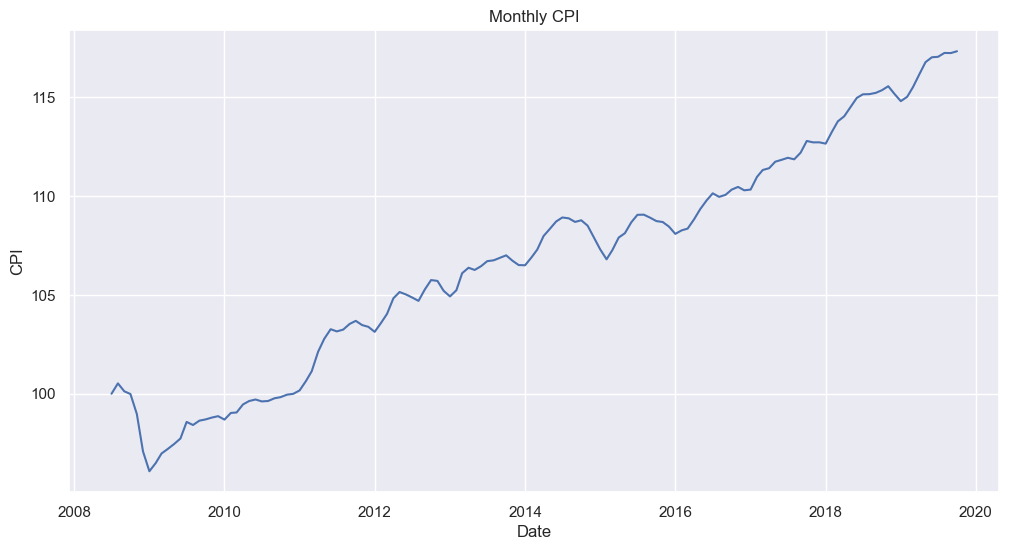

In [2]:
# Load the CPI data
df_cpi = pd.read_csv(
    './Datasets/CPI.csv',
    parse_dates=['date'],
)

# Print the columns of each dataframe
print("CPI Columns", list(df_cpi.columns))
print()

# Take the first CPI value of each month as that month's CPI
# (The element that does the trick here is the "freq='MS'" argument
# which tells the grouper to group by month start)
grouped_df_cpi = df_cpi.groupby(pd.Grouper(key='date', freq='MS')).first()

# Flatten the grouped_df_cpi dataframe to have two columns again
df_cpi_monthly = grouped_df_cpi.reset_index()

# Remove nan values from the CPI data
df_cpi_monthly = df_cpi_monthly.dropna()

# Print the shapes of the dataframes
print("Full CPI Data Shape:", df_cpi.shape)
print("Monthly CPI Data Shape:", df_cpi_monthly.shape)

# ==================== ARRAY =================== #

# Create an additional column for the array that contains the row index
cpi_indexes = np.arange(0, df_cpi_monthly.shape[0])

# Turn the CPI data into an array
cpi_array = df_cpi_monthly.values

# Add the CPI indexes to the array
cpi_array = np.hstack((cpi_indexes.reshape(-1, 1), cpi_array))

# ==================== PLOT ==================== #

plt.figure(figsize=(12, 6))
plt.plot(df_cpi_monthly['date'], df_cpi_monthly['CPI'])
plt.title('Monthly CPI')
plt.xlabel('Date')
plt.ylabel('CPI')
plt.show()

### Train Test Split


In [3]:
# The CPI data is split in the following way:
# - Training data spans from July 2008 to August 2013
# - Test data spans from September 2013 to October 2019
train_end_date = '2013-08-01'
test_start_date = '2013-09-01'

# Convert the dates to datetime objects
train_end_date = pd.to_datetime(train_end_date)
test_start_date = pd.to_datetime(test_start_date)

# Create the training data
train_data = cpi_array[cpi_array[:, 1] < train_end_date]
test_data = cpi_array[cpi_array[:, 1] >= test_start_date]

# Divide the data into X and y
X_train = train_data[:, 0].reshape(-1, 1)
y_train = train_data[:, 2].reshape(-1, 1)
X_test = test_data[:, 0].reshape(-1, 1)
y_test = test_data[:, 2].reshape(-1, 1)

### Detrend CPI


Intercept (alpha 0) 96.73595325224746
Slope (alpha 1) 0.16071213749338967


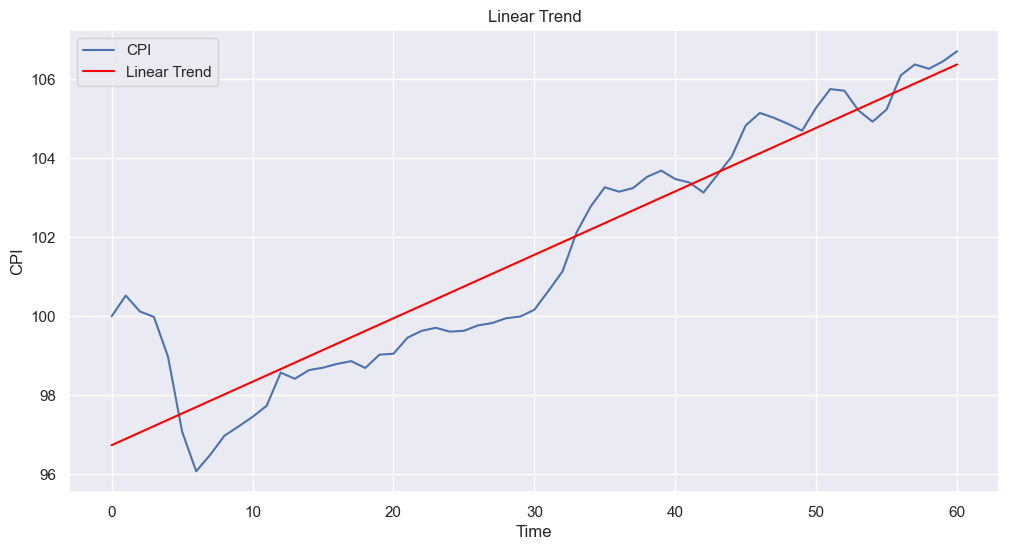

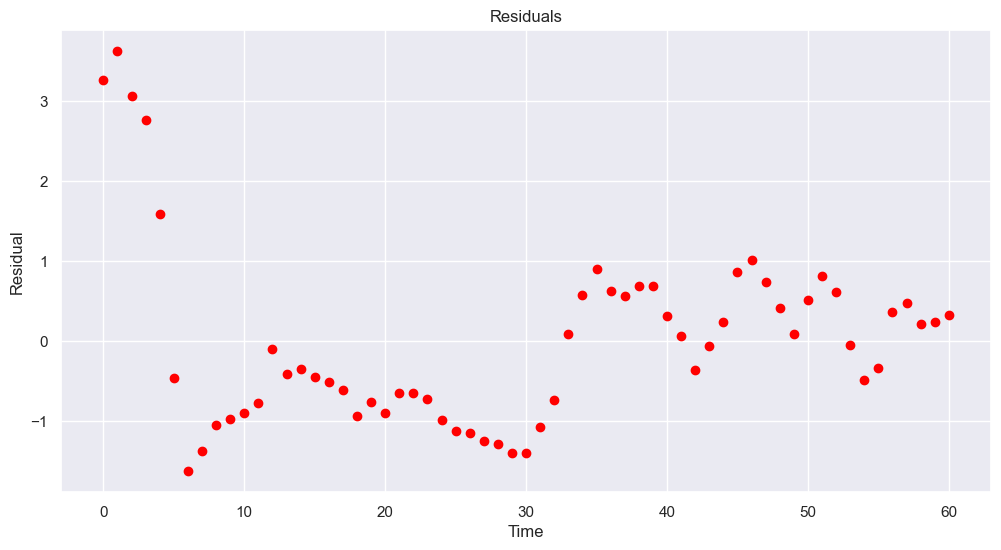

Max Residual 3.6284346102591485


In [4]:
# Set the training data
X = X_train.copy()
y = y_train.copy()

# ================ LINEAR TREND ================ #

# Create a linear regression fit on the data
trend_fit = LinearRegression().fit(X, y)

# Predict the CPI values for the train set
y_pred = trend_fit.predict(X)

# Fetch the coefficients of the linear fit
intercept = trend_fit.intercept_[0]
slope = trend_fit.coef_[0][0]

# Print the coefficients
print("Intercept (alpha 0)", intercept)
print("Slope (alpha 1)", slope)

# Plot the linear trend
plt.figure(figsize=(12, 6))
plt.plot(X, y, label='CPI')
plt.plot(X, y_pred, color='red', label='Linear Trend')
plt.title('Linear Trend')
plt.xlabel('Time')
plt.ylabel('CPI')
plt.legend()
plt.show()

# ================== RESIDUALS ================= #

# Calculate the residuals
residuals = y - y_pred

# Plot the residuals
plt.figure(figsize=(12, 6))
plt.scatter(X, residuals, color='red')
plt.title('Residuals')
plt.xlabel('Time')
plt.ylabel('Residual')
plt.show()

# Get the maximum absolute value of the residuals
max_residual = np.max(np.abs(residuals))
print("Max Residual", max_residual)

### AR Model: Determine the Lag


c:\Users\eddysanoli\AppData\Local\pypoetry\Cache\virtualenvs\data_analysis-ayydRhdv-py3.9\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


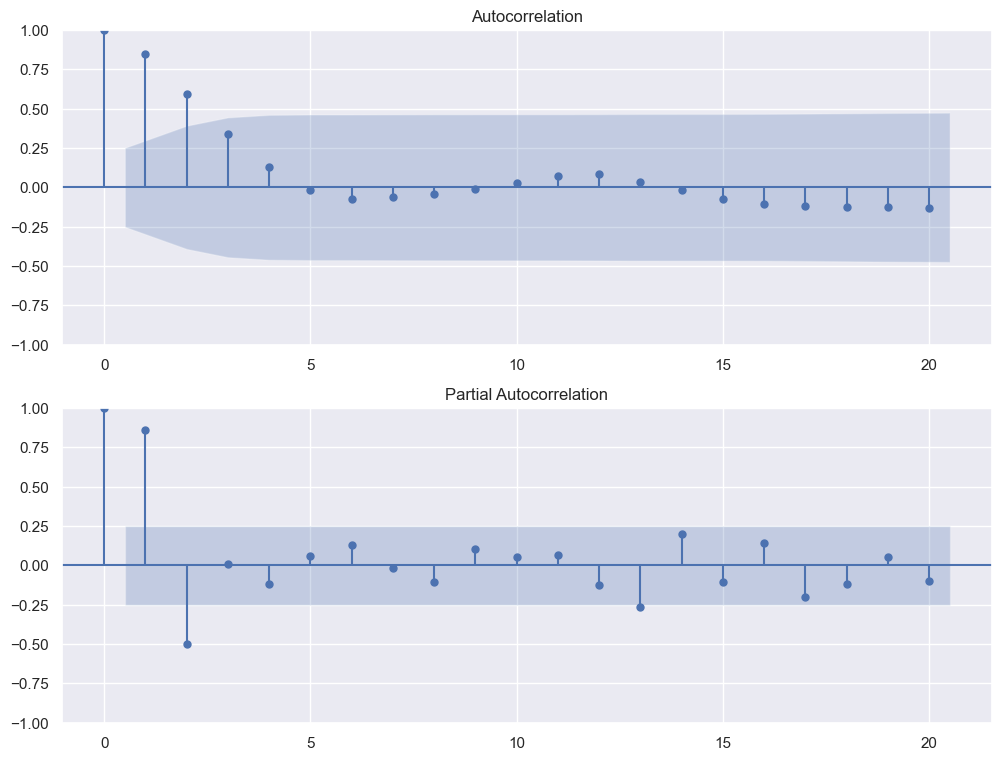

The ACF plot shows a strong correlation for the first 2 lags (they appear 
above the confidence interval), suggesting that the order 'p' of the 
AR model should be 2. The PACF plot won't be used yet, since we are not 
analyzing an MA model yet.


In [5]:
# Plot the ACF and PACF of the residuals
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 9))
plot_acf(residuals, lags=20, ax=ax1)
plot_pacf(residuals, lags=20, ax=ax2)
plt.show()

print("The ACF plot shows a strong correlation for the first 2 lags (they appear ")
print("above the confidence interval), suggesting that the order 'p' of the ")
print("AR model should be 2. The PACF plot won't be used yet, since we are not ")
print("analyzing an MA model yet.")

### AR Model: Find the Parameters


See the 'y.L1' and 'y.L2' coefficients in the summary below for the
phi_1 and phi_2 coefficients of the AR model.

                            AutoReg Model Results                             
Dep. Variable:                      y   No. Observations:                   61
Model:                     AutoReg(2)   Log Likelihood                 -17.711
Method:               Conditional MLE   S.D. of innovations              0.327
Date:                Wed, 19 Apr 2023   AIC                             43.422
Time:                        06:03:21   BIC                             51.732
Sample:                             2   HQIC                            46.666
                                   61                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0411      0.043     -0.960      0.337      -0.125       0.043
y.L1           1

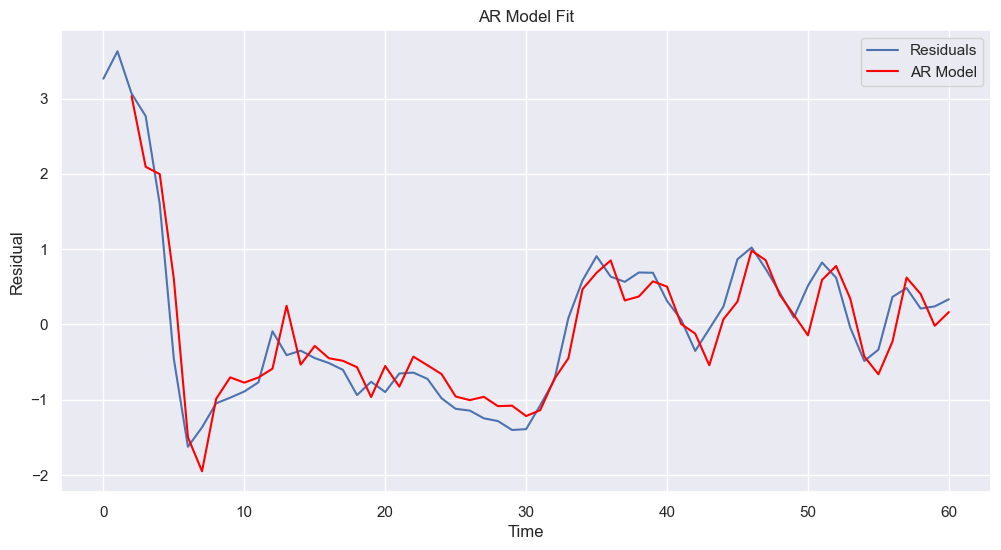

In [6]:
# Fit an AR(2) model on the residuals
p = 2
ar_model = AutoReg(residuals, lags=p, old_names=False).fit()

# Print the summary of the AR model
print("See the 'y.L1' and 'y.L2' coefficients in the summary below for the")
print("phi_1 and phi_2 coefficients of the AR model.")
print()
print(ar_model.summary())

# Plot the AR model predictions
plt.figure(figsize=(12, 6))
plt.plot(X, residuals, label='Residuals')
plt.plot(X, ar_model.predict(), color='red', label='AR Model')
plt.title('AR Model Fit')
plt.xlabel('Time')
plt.ylabel('Residual')
plt.legend()
plt.show()

### Mean Squared Error


2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75


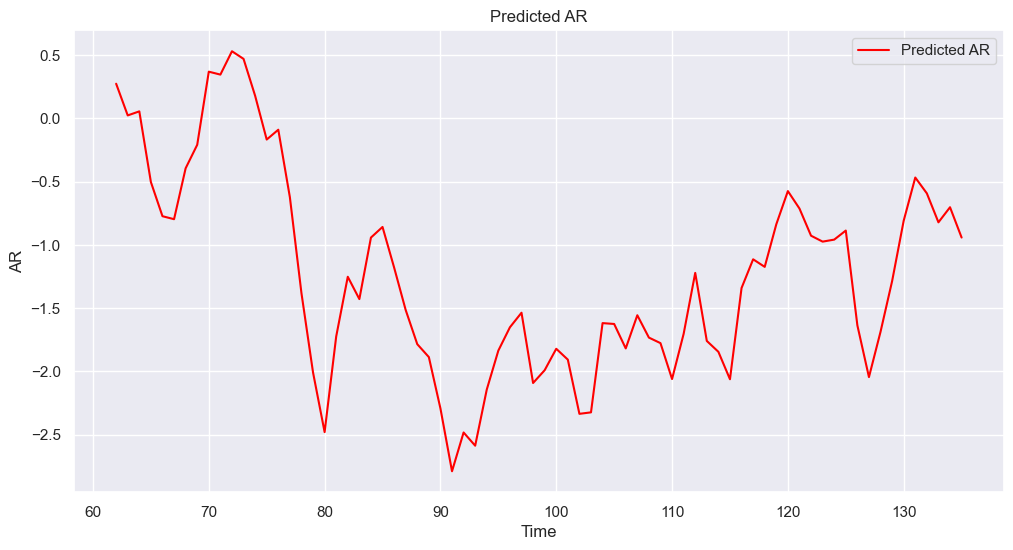

RMSE: 0.38730980891932343


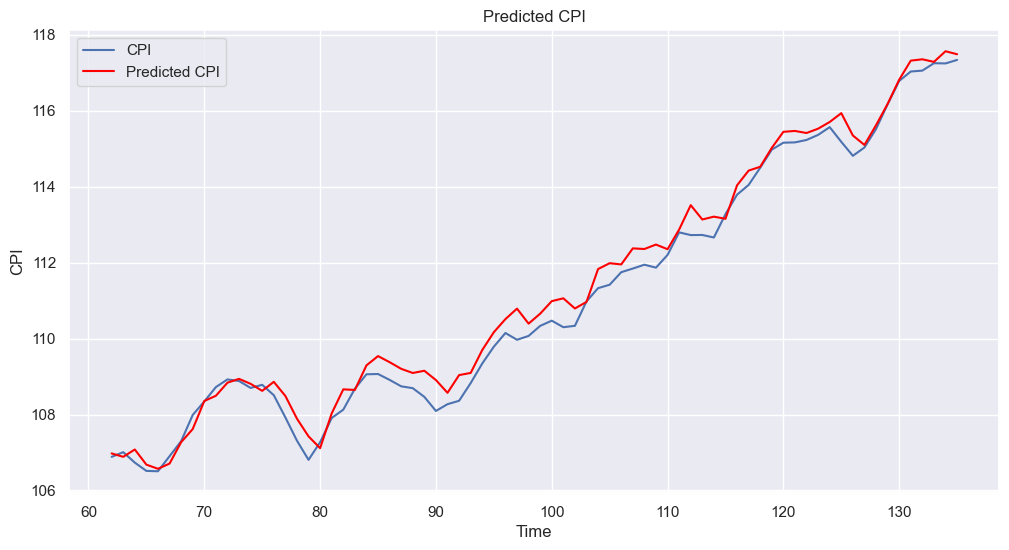

In [7]:
# ================ TREND REMOVAL =============== #

# Predict the CPI trend
y_pred_trend = trend_fit.predict(X_test)

# Remove the trend to calculate the AR predictions
residuals_test = y_test - y_pred_trend

# ===== MANUALLY CALCULATED AR PREDICTIONS ===== #

# Fetch the coefficients of the AR model
epsilon = ar_model.params[0]
phi_1 = ar_model.params[1]
phi_2 = ar_model.params[2]

# Create a new AR dataset:
# - Include the last 2 values from the training set residuals, since they
#   are needed to calculate the first prediction (lag of AR model = 2)
# - Add the residuals calculated for the test set after removing the trend
# - Optional: This last step doesn't make sense to me. You shouldn't be able
#   to add the residuals for the test set, since in a real scenario you wouldn't
#   have access to them, you are trying to predict them. Seems like this is the
#   answer, but I don't understand why. I left commented out the version where
#   instead of including the test residuals, I just add 0s to simulate a real
#   scenario (it even makes more sense, as the test residuals should tend to the
#   mean of the values)
ar_data = np.vstack((residuals[-2:], residuals_test))

# Generate the AR predictions for the test set using the coefficients
y_pred_ar = np.zeros(len(X_test))
for i in range(2, len(ar_data)):

    # Calculate the AR prediction
    y_pred_ar[i - 2] = (
        epsilon +
        phi_1 * ar_data[i - 1] +
        phi_2 * ar_data[i - 2]
    )

    # This only uses the past 2 values to calculate the next prediction.
    # Uncomment to see a similar output to what the AutoReg.predict() method
    # returns.
    # ar_data[i] = y_pred_ar[i - 2]


# ================ PREDICTED AR ================ #

# Plot the predicted AR values
plt.figure(figsize=(12, 6))
plt.plot(X_test, y_pred_ar, color='red', label='Predicted AR')
plt.title('Predicted AR')
plt.xlabel('Time')
plt.ylabel('AR')
plt.legend()
plt.show()

# =========== PREDICTED CPI AND RMSE =========== #

# Flatten predicted values for the trend and the AR model
y_pred_trend = y_pred_trend.flatten()
y_pred_ar = y_pred_ar.flatten()

# Calculate the predicted CPI values by adding the trend and AR
y_pred_cpi = y_pred_trend + y_pred_ar

# Calculate the RMSE of the predictions
rmse = mean_squared_error(
    y_test,
    y_pred_cpi,
    squared=False
)
print("RMSE:", rmse)

# =============== PREDICTION PLOT ============== #

# Plot the predictions
plt.figure(figsize=(12, 6))
plt.plot(X_test, y_test, label='CPI')
plt.plot(X_test, y_pred_cpi, color='red', label='Predicted CPI')
plt.title('Predicted CPI')
plt.xlabel('Time')
plt.ylabel('CPI')
plt.legend()
plt.show()

### Inflation Rate from CPI

$$
\text {IR}_ t = \frac{\text {CPI}_ t -\text {CPI}_{t-1}}{\text {CPI}_{t-1}}
$$

$$
\text {IR}_ t = \ln (\text {CPI}_ t) -\ln (\text {CPI}_{t-1})
$$


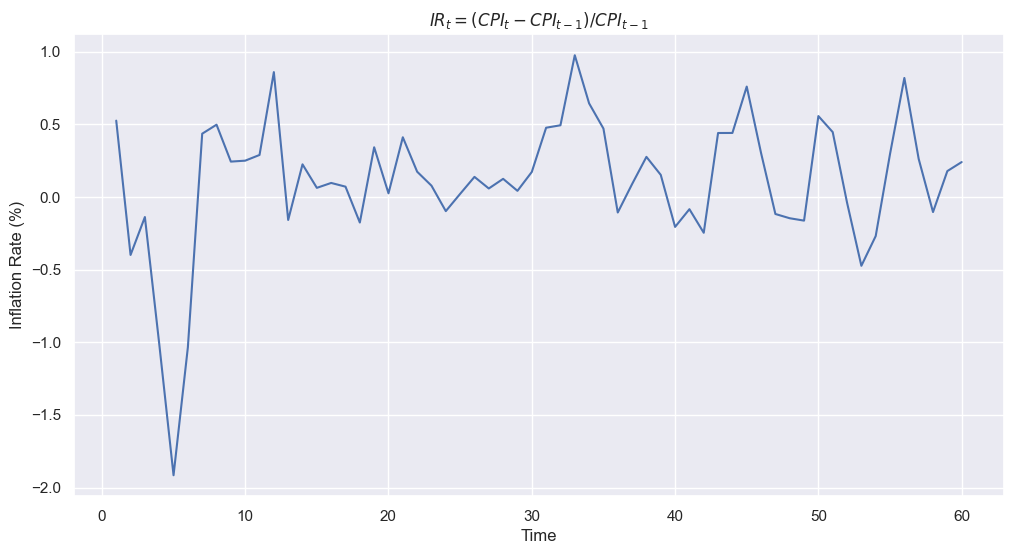

Inflation rate for February 2013: 0.2957229296297584


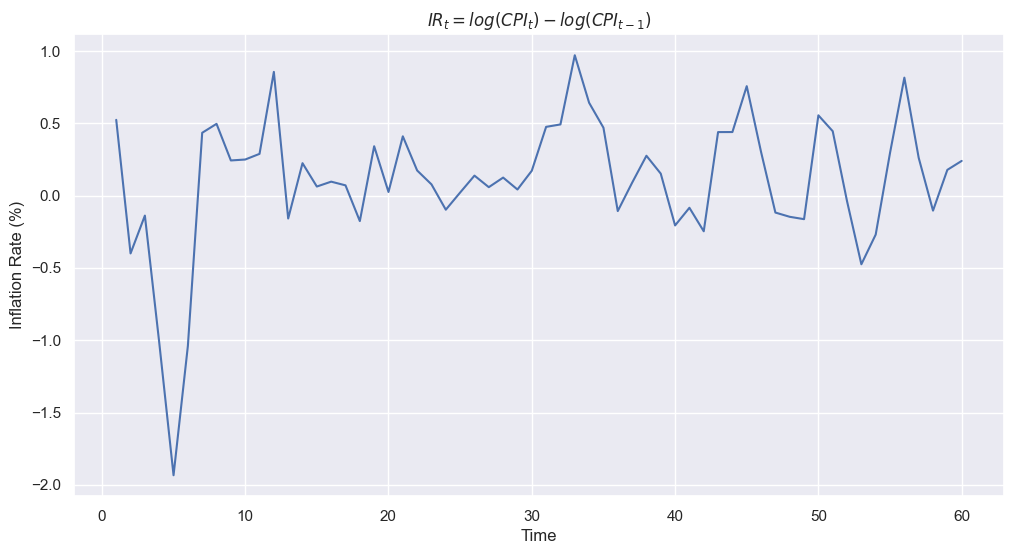

Inflation rate for February 2013 (Difference of Logarithms): 0.2952865295193341


In [8]:
# ============== PERCENTAGE CHANGE ============= #

# Calculate the inflation rate as the percentage change
# between the CPI values
inflation_rate = (np.diff(y, axis=0) / y[:-1]) * 100

# Plot the inflation rate
plt.figure(figsize=(12, 6))
plt.plot(X[1:], inflation_rate, label='Inflation Rate')
plt.title('$IR_t = (CPI_t - CPI_{t-1}) / CPI_{t-1}$')
plt.xlabel('Time')
plt.ylabel('Inflation Rate (%)')
plt.show()

# Get the index where the second column of the CPI dataset is equal
# to february 2013
february_2013 = pd.to_datetime('2013-02-01')
february_2013_idx = np.where(cpi_array[:, 1] == february_2013)[0][0]

# Subtract 1 from the february 2013 index since the inflation rate
# is calculated as the percentage change between the CPI values
february_2013_idx -= 1

# Get the inflation rate for february 2013
february_2013_inflation_rate = inflation_rate[february_2013_idx]
print("Inflation rate for February 2013:", february_2013_inflation_rate[0])

# ========== DIFFERENCE OF LOGARITHMS ========== #

# Calculate the inflation rate as the difference of logarithms
# between the CPI values
y_log = np.log(np.array(y, dtype=np.float64))
inflation_rate_log = np.diff(y_log, axis=0) * 100

# Plot the inflation rate
plt.figure(figsize=(12, 6))
plt.plot(X[1:], inflation_rate_log, label='Inflation Rate')
plt.title('$IR_t = log(CPI_t) - log(CPI_{t-1})$')
plt.xlabel('Time')
plt.ylabel('Inflation Rate (%)')
plt.show()

# Get the inflation rate for february 2013
february_2013_inflation_rate_log = inflation_rate_log[february_2013_idx]
print(
    "Inflation rate for February 2013 (Difference of Logarithms):",
    february_2013_inflation_rate_log[0]
)


### Inflation Rate Model Fitting

#### Dataset


In [9]:
IR_train = (np.diff(y, axis=0) / y[:-1]) * 100
IR_test = (np.diff(y_test, axis=0) / y_test[:-1]) * 100
ts_train = X_train[1:]
ts_test = X_test[1:]


#### Detrending Inflation Rate


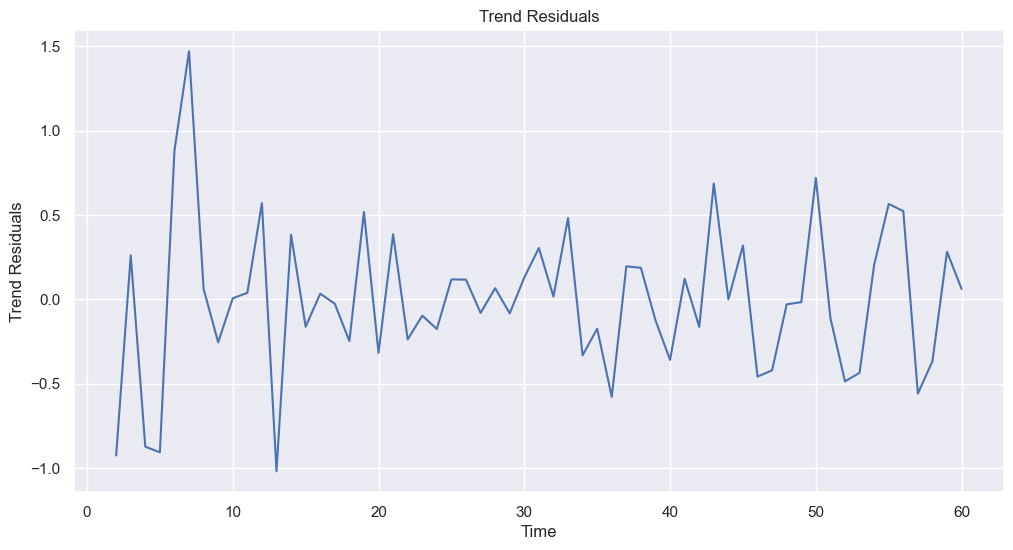

Are the trend residuals stationary? True


In [10]:
# Select the detrending method to use.
# Notes:
# - "linear-fit": Does not seem to properly detrend the data
# - "diff": Seems to work better, but it is not clear why
detrending_method = "diff"

# ================ METHOD LOGIC ================ #

if detrending_method == "linear-fit":

    # Fit a linear regression model to the inflation rate
    trend_fit = LinearRegression().fit(ts_train, IR_train)
    IR_pred = trend_fit.predict(ts_train)

    # Fetch the coefficients of the linear regression model
    slope = trend_fit.coef_[0][0]
    intercept = trend_fit.intercept_[0]

    # Plot the linear trend
    plt.figure(figsize=(12, 6))
    plt.plot(ts_train, IR_train, label='Inflation Rate')
    plt.plot(
        ts_train,
        IR_pred,
        color='red',
        label=f'Predicted Trend: {slope:.2f}t + ({intercept:.2f})'
    )
    plt.title('Predicted Trend')
    plt.xlabel('Time')
    plt.ylabel('Inflation Rate')
    plt.legend()
    plt.show()

    # Calculate the trend residuals of the inflation rate for the train data. Then
    # flatten them and convert them to a float64 type in order to use them in the
    # ARIMA model.
    trend_residuals_train = IR_train - IR_pred
    trend_residuals_train = trend_residuals_train.flatten()
    trend_residuals_train = trend_residuals_train.astype(np.float64)

    # Calculate the test data trend residuals
    trend_residuals_test = IR_test - trend_fit.predict(ts_test)
    trend_residuals_test = trend_residuals_test.flatten()
    trend_residuals_test = trend_residuals_test.astype(np.float64)

    # Set the X-axis data for the trend
    ts_train_trend = ts_train.copy()

elif detrending_method == "diff":

    # Number of differences to take
    d = 1

    # Establish the initial value of the inflation rate residuals
    trend_residuals_train = IR_train.copy()
    trend_residuals_test = IR_test.copy()

    # Differenciate as many times as specified by the d variable
    for i in range(d):
        trend_residuals_train = np.diff(trend_residuals_train, axis=0)
        trend_residuals_test = np.diff(trend_residuals_test, axis=0)

    # Flatten the trend residuals and convert them to a float64 type in order to
    # use them in the ARIMA model.
    trend_residuals_train = trend_residuals_train.flatten()
    trend_residuals_train = trend_residuals_train.astype(np.float64)
    trend_residuals_test = trend_residuals_test.flatten()
    trend_residuals_test = trend_residuals_test.astype(np.float64)

    # Set the X-axis data for the trend
    ts_train_trend = ts_train[d:]

else:
    raise ValueError("Invalid detrending method")

# Plot the trend residuals
plt.figure(figsize=(12, 6))
plt.plot(ts_train_trend, trend_residuals_train, label='Trend Residuals')
plt.title('Trend Residuals')
plt.xlabel('Time')
plt.ylabel('Trend Residuals')
plt.show()

# Check if the trend residuals are stationary
print(
    "Are the trend residuals stationary?",
    adfuller(trend_residuals_train)[1] < 0.05
)


#### Choosing an AR Model


In [11]:
list(range(1, 10))


[1, 2, 3, 4, 5, 6, 7, 8, 9]

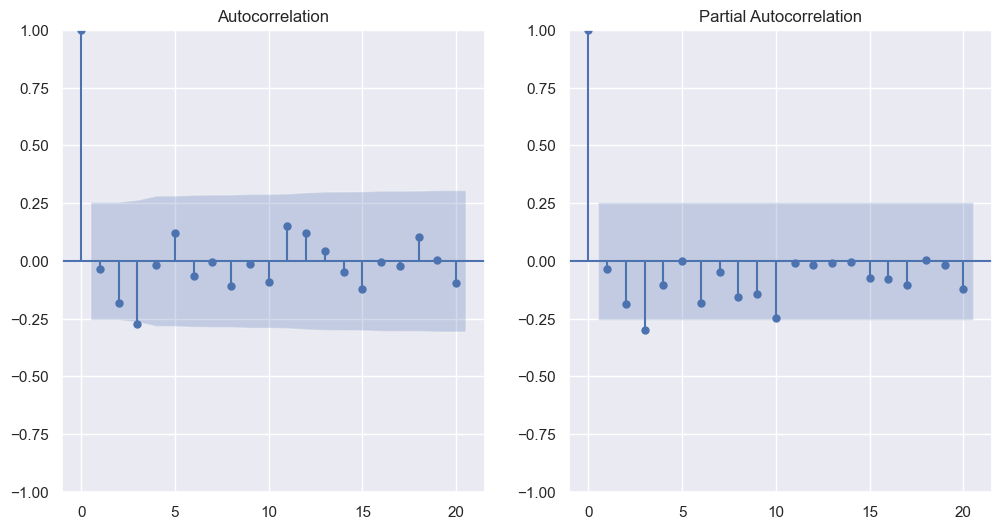

0 -1
1 0
2 1
3 2
4 3
5 4
6 5
7 6
8 7
9 8
10 9
11 10
12 11
13 12
14 13
15 14
16 15
17 16
18 17
19 18
20 19
21 20
22 21
23 22
24 23
25 24
26 25
27 26
28 27
29 28
30 29
31 30
32 31
33 32
34 33
35 34
36 35
37 36
38 37
39 38
40 39
41 40
42 41
43 42
44 43
45 44
46 45
47 46
48 47
49 48
50 49
51 50
52 51
53 52
54 53
55 54
56 55
57 56
58 57
59 58
60 59
61 60
62 61
63 62
64 63
65 64
66 65
67 66
68 67
69 68
70 69
71 70
72 71
0 -1
0 -2
1 0
1 -1
2 1
2 0
3 2
3 1
4 3
4 2
5 4
5 3
6 5
6 4
7 6
7 5
8 7
8 6
9 8
9 7
10 9
10 8
11 10
11 9
12 11
12 10
13 12
13 11
14 13
14 12
15 14
15 13
16 15
16 14
17 16
17 15
18 17
18 16
19 18
19 17
20 19
20 18
21 20
21 19
22 21
22 20
23 22
23 21
24 23
24 22
25 24
25 23
26 25
26 24
27 26
27 25
28 27
28 26
29 28
29 27
30 29
30 28
31 30
31 29
32 31
32 30
33 32
33 31
34 33
34 32
35 34
35 33
36 35
36 34
37 36
37 35
38 37
38 36
39 38
39 37
40 39
40 38
41 40
41 39
42 41
42 40
43 42
43 41
44 43
44 42
45 44
45 43
46 45
46 44
47 46
47 45
48 47
48 46
49 48
49 47
50 49
50 48
51 50
51 4

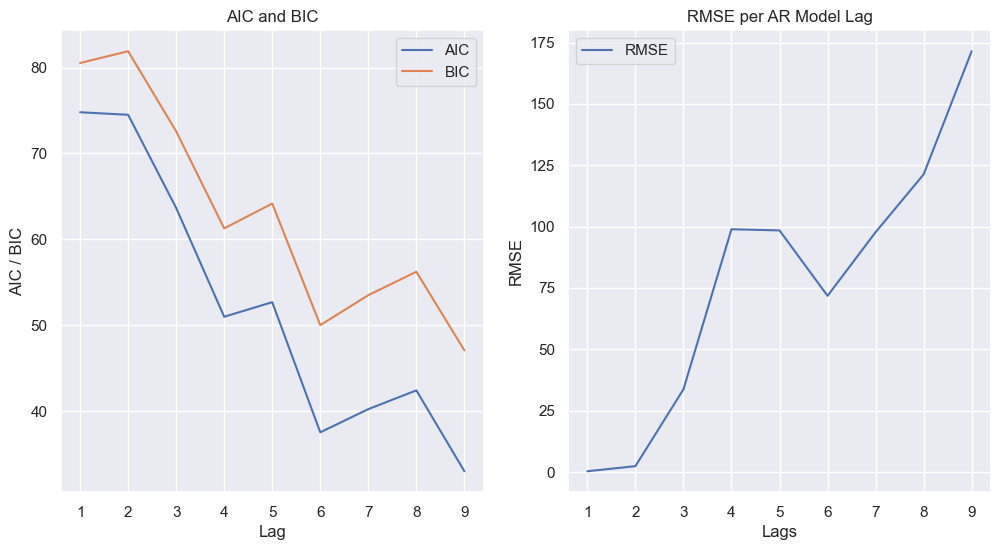

In [17]:
# Plot the ACF and PACF plots side by side
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))
plot_acf(trend_residuals_train, lags=20, ax=ax1)
plot_pacf(trend_residuals_train, lags=20, method="ywm", ax=ax2)
plt.show()


# Calculate a model for different lags
ar_models = []
lags = list(range(1, 10))
for lag in lags:

    # Fit an AR model to the trend residuals
    ar_fit = AutoReg(trend_residuals_train, lags=lag).fit()

    # Include the last two values of the ts_train array in the test ts array
    # as the AR model will need them to make from new data
    ar_ts_test = np.append(ts_train_trend[-lag:], ts_test)

    # Get the AR model coefficients
    epsilon = ar_fit.params[0]

    # Get the phi coefficients for each lag
    phi = [
        ar_fit.params[i+1] for i in range(lag)
    ]

    # Generate the AR predictions for the test set using the coeffs
    ar_pred = np.zeros(len(ts_test))
    for i in range(lag, len(ar_ts_test)):
        idx = i - lag
        ar_pred[idx] = epsilon
        for j in range(1, lag):
            ar_pred[idx] += phi[j-1] * ar_ts_test[idx-j]
            print(idx, idx - j)

    # We remove the first prediction just to make the dimensions fit
    ar_pred = ar_pred[1:]
    ar_pred = ar_pred.flatten()

    # Calculate the AIC and BIC
    aic = ar_fit.aicc
    bic = ar_fit.bic

    # Calculate the RMSE
    rmse = mean_squared_error(
        trend_residuals_test,
        ar_pred,
        squared=False
    )

    # Statistics for each model
    ar_models.append({
        'model': ar_fit,
        'predictions': ar_pred,
        'lag': lag,
        'aic': aic,
        'bic': bic,
        'rmse': rmse
    })

# Get the statistics for each lag
aic = [model['aic'] for model in ar_models]
bic = [model['bic'] for model in ar_models]
rmse = [model['rmse'] for model in ar_models]

# Plot the AIC + BIC and RMSE side by side
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))
ax1.plot(lags, aic, label='AIC')
ax1.plot(lags, bic, label='BIC')
ax1.set_title('AIC and BIC')
ax1.set_xlabel('Lag')
ax1.set_ylabel('AIC / BIC')
ax1.legend()

ax2.plot(lags, rmse, label='RMSE')
ax2.set_title('RMSE per AR Model Lag')
ax2.set_xlabel('Lags')
ax2.set_ylabel('RMSE')
ax2.legend()
plt.show()

#### Final Model


RMSE: 0.2755726409280015


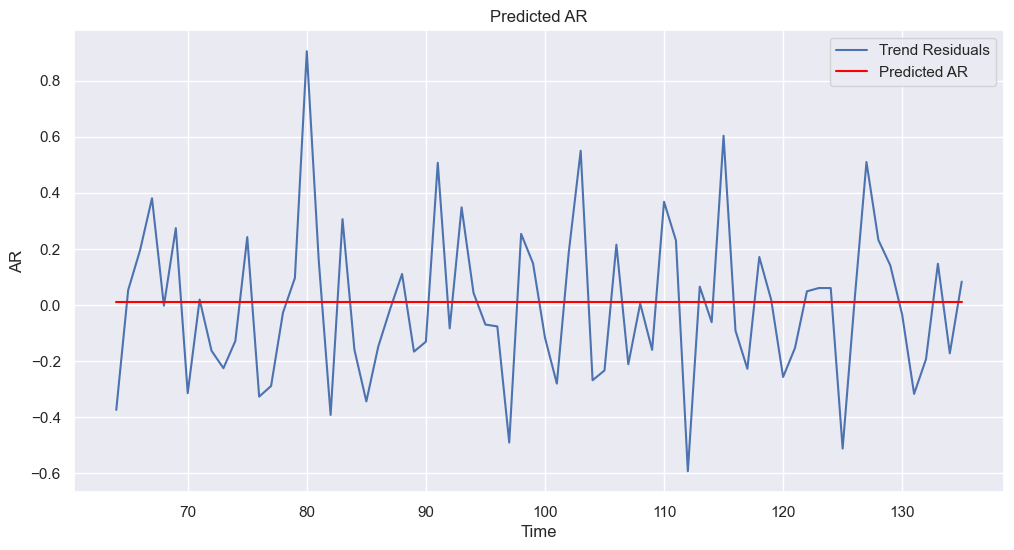

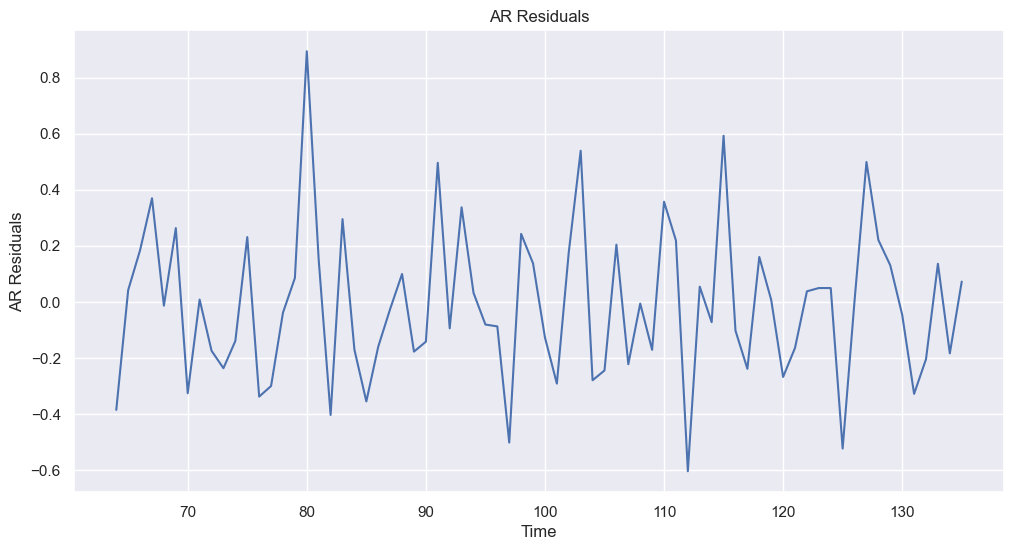

In [16]:
best_model_lag = 1

# Get the best model
best_model = ar_models[best_model_lag-1]

# Get the best model based on the lag value
best_model_preds = best_model['predictions']

# Print the rmse
print("RMSE:", best_model['rmse'])

# Plot the AR model predictions
plt.figure(figsize=(12, 6))
plt.plot(ts_test[1:], trend_residuals_test, label='Trend Residuals')
plt.plot(ts_test[1:], best_model_preds, color='red', label='Predicted AR')
plt.title('Predicted AR')
plt.xlabel('Time')
plt.ylabel('AR')
plt.legend()
plt.show()

# ================== REMOVE AR ================= #

ar_residuals = trend_residuals_test - best_model_preds

# Plot the AR residuals
plt.figure(figsize=(12, 6))
plt.plot(ts_test[1:], ar_residuals, label='AR Residuals')
plt.title('AR Residuals')
plt.xlabel('Time')
plt.ylabel('AR Residuals')
plt.show()


### Inflation Rate from BER

$$
\text {BER}^{\text {monthly}}_ t = (\text {BER}^{\text {yearly}}_ t +1)^\frac {1}{12} -1
$$


            date   BER
1433  2008-07-01  2.52
1434  2008-07-02  2.56
1435  2008-07-03  2.57
1437  2008-07-07  2.52
1438  2008-07-08  2.46
...          ...   ...
4388  2019-10-29  1.61
4389  2019-10-30  1.57
4390  2019-10-31  1.54
4391  2019-11-01  1.59
4392  2019-11-04  1.64

[2839 rows x 2 columns]


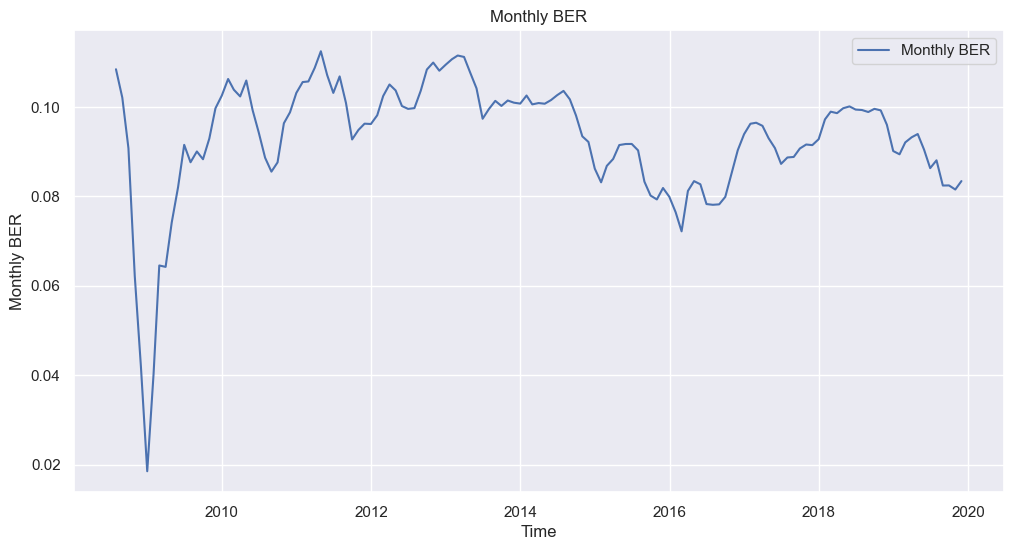

BER for February 2013: 0.11147736108051642


In [10]:
# Load the break-even rate data
df_ber = pd.read_csv('./Datasets/T10YIE.csv')

# Rename the columns of the BER dataset
df_ber.columns = ['date', 'BER']

# We drop the null values and all the values from before 2008
# (for some reason, got no idea why)
df_ber = df_ber.drop(df_ber[df_ber['date'] < '2008-07-01'].index)
df_ber = df_ber.dropna()

print(df_ber)

# Convert the date column to datetime
df_ber['date'] = pd.to_datetime(df_ber['date'])

# We get the average of the BER values over each month as a monthly
# representative
# monthly_representative = df_ber.groupby(
#     pd.Grouper(key='date', freq='MS')
# ).mean()
df_ber_monthly = df_ber.resample('M', on="date").mean()

# Flatten the headers so that we get 2 regular columns
df_ber_monthly = df_ber_monthly.reset_index()

# Separate the BER data into a

# The monthly representative will be assumed to consist of the
# "BER yearly" value in the formula above. Now we just plug the
# "yearly" value into the formula to get the monthly value
yearly_ber = df_ber_monthly["BER"].to_numpy()
monthly_ber = (yearly_ber + 1)**(1/12) - 1

# Plot the monthly BER
plt.figure(figsize=(12, 6))
plt.plot(
    df_ber_monthly['date'],
    monthly_ber,
    label='Monthly BER'
)
plt.title('Monthly BER')
plt.xlabel('Time')
plt.ylabel('Monthly BER')
plt.legend()
plt.show()

# The monthly BER is turned into a percentage by multiplying by 100
# monthly_ber = monthly_ber * 100

# Get the index where the BER date is equal to february 2013
february_2013_idx = np.where(
    df_ber_monthly['date'] == pd.to_datetime("2013-02-28")
)[0][0]

# Get the BER for february 2013
february_2013_ber = monthly_ber[february_2013_idx]
print("BER for February 2013:", february_2013_ber)